# 机器学习之多分类学习

#### 【简介】

在现实生活中，很多问题并非“非黑即白”的问题，而是可以分为多个不同的类别，这些问题可以视为**多分类学习**任务。

多分类学习任务可以基于二分类算法进行推广后解决。有些二分类算法可以直接推广用于解决多分类问题，但是在更多情形下需要基于一些基本策略来对二分类算法进行处理从而更有效的解决多分类问题。

最经典和最基础的**拆分策略**包括两种：“一对一”（One vs. One，简称**OvO**）和“一对其余”（“One vs. Rest”，简称**OvR**）。

#### 【目录】

1. [OvO多分类策略](#1.-OvO多分类策略)
2. [OvR多分类策略](#2.-OvR多分类策略)

## 1. OvO多分类策略

### 任务描述

根据所学知识完成基于 OvO 策略的多分类模型训练与预测，实现多分类任务。

### 相关知识

#### OvO

假设现在训练数据集的分布如下图所示（其中A，B，C代表训练数据的类别）：

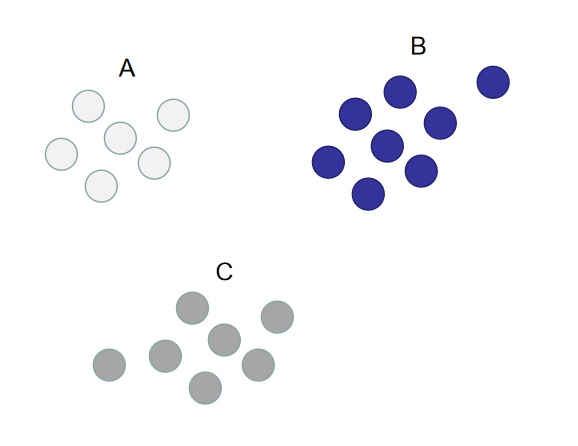

如果想要使用**逻辑回归**算法来解决这种3分类问题，可以使用**OvO**。OvO(One Vs One)是**使用二分类算法来解决多分类问题**的一种策略。从字面意思可以看出它的核心思想就是一对一。所谓的“一”，指的是类别。而“对”指的是从训练集中划分不同的两个类别的组合来训练出多个分类器。

划分的规则很简单，就是组合($C_n^2$，其中n表示训练集中类别的数量，在这个例子中为3)。如下图所示(其中每一个矩形框代表一种划分)：

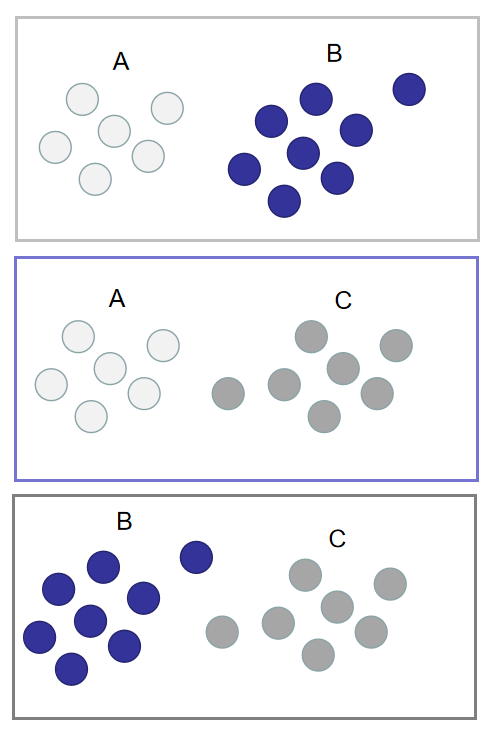

分别用这3种划分，划分出来的训练集训练**二分类分类器**，就能得到3个分类器。此时训练阶段已经完毕。如下图所示：

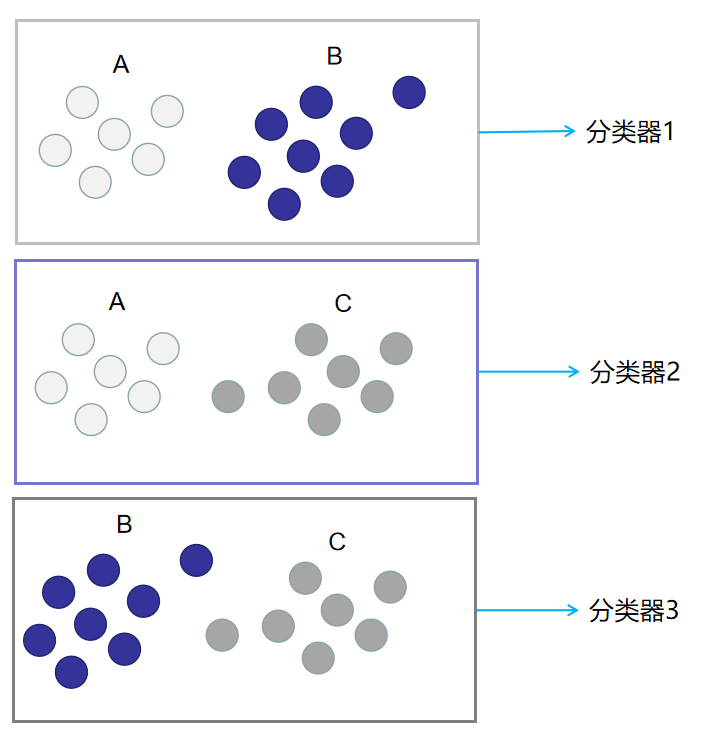

在预测阶段，只需要将测试样本分别扔给训练阶段训练好的3个分类器进行预测，最后将3个分类器预测出的结果进行投票统计，**票数最高**的结果为预测结果。如下图所示：

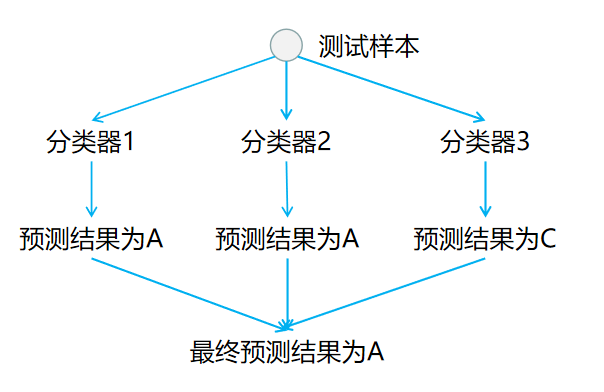

## 实操练习

### 编程要求

根据提示，补充`Begin-End`之间的代码，完成OvO类中的`fit(self, train_datas, train_labels)`与`predict(self, test_datas)`函数。**PS:请使用代码中所提供的tiny_logistic_regression作为二分类分类器**。

### 测试说明

输出预测准确率，应高于0.85

In [74]:
import numpy as np
# 逻辑回归
class tiny_logistic_regression(object):
    def __init__(self):
        #W
        self.coef_ = None
        #b
        self.intercept_ = None
        #所有的W和b
        self._theta = None
        #01到标签的映射
        self.label_map = {}
    def _sigmoid(self, x):
        return 1. / (1. + np.exp(-x))
    #训练
    def fit(self, train_datas, train_labels, learning_rate=1e-4, n_iters=1e3):
        #loss
        def J(theta, X_b, y):
            y_hat = self._sigmoid(X_b.dot(theta))
            try:
                return -np.sum(y*np.log(y_hat)+(1-y)*np.log(1-y_hat)) / len(y)
            except:
                return float('inf')
        # 算theta对loss的偏导
        def dJ(theta, X_b, y):
            return X_b.T.dot(self._sigmoid(X_b.dot(theta)) - y) / len(y)
        # 批量梯度下降
        def gradient_descent(X_b, y, initial_theta, leraning_rate, n_iters=1e2, epsilon=1e-6):
            theta = initial_theta
            cur_iter = 0
            while cur_iter < n_iters:
                gradient = dJ(theta, X_b, y)
                last_theta = theta
                theta = theta - leraning_rate * gradient
                if (abs(J(theta, X_b, y) - J(last_theta, X_b, y)) < epsilon):
                    break
                cur_iter += 1
            return theta
        
        unique_labels = list(set(train_labels))
        labels = train_labels.copy()
        self.label_map[0] = unique_labels[0]
        labels[train_labels == unique_labels[0]] = 0
        self.label_map[1] = unique_labels[1]
        labels[train_labels == unique_labels[1]] = 1
        X_b = np.hstack([np.ones((len(train_datas), 1)), train_datas])
        initial_theta = np.zeros(X_b.shape[1])
        self._theta = gradient_descent(X_b, labels, initial_theta, learning_rate, n_iters)
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        return self
    
    #预测概率分布
    def predict_proba(self, X):
        X_b = np.hstack([np.ones((len(X), 1)), X])
        return self._sigmoid(X_b.dot(self._theta))
    
    #预测
    def predict(self, X):
        proba = self.predict_proba(X)
        result = np.array(proba >= 0.5, dtype='int')
        for i in range(len(result)):
            if result[i] == 0:
                result[i] = self.label_map[0]
            else:
                result[i] = self.label_map[1]
        
        return result
    
class OvO(object):
    def __init__(self):
        # 用于保存训练时各种模型的list
        self.models = []
    def fit(self, train_datas, train_labels):
        '''
        OvO的训练阶段，将模型保存到self.models中
        :param train_datas: 训练集数据，类型为ndarray
        :param train_labels: 训练集标签，类型为ndarray，shape为(-1,)
        :return:None
        '''
        #********* Begin *********#
        unique_labels = list(set(train_labels))
        for i in range(len(unique_labels)):
            for j in range(i+1, len(unique_labels)):
                datas = train_datas[(train_labels == unique_labels[i]) | (train_labels == unique_labels[j])]
                labels = train_labels[(train_labels == unique_labels[i]) | (train_labels == unique_labels[j])]
                lr = tiny_logistic_regression()
                lr.fit(datas, labels)
                self.models.append(lr)
        #********* End *********#
    def predict(self, test_datas):
        '''
        OvO的预测阶段
        :param test_datas:测试集数据，类型为ndarray
        :return:预测结果，类型为ndarray
        '''
        #********* Begin *********#
        def _predict(models, test_data):
            # 变形
            test_data = np.reshape(test_data, (1, -1))
            vote = {}
            # 计票
            for model in models:
                pred = model.predict(test_data)[0]
                if pred not in vote:
                    vote[pred] = 1
                else:
                    vote[pred] += 1
            vote = sorted(vote.items(), key=lambda x: x[1], reverse=True)
            return vote[0][0]
        predict = []
        for data in test_datas:
            predict.append(_predict(self.models, data))
        return np.array(predict)
        #********* End *********#

In [83]:
# 使用sklearn.datasets模块的iris数据集进行测试
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# 加载iris数据集
iris = load_iris()
# 标准化
X = StandardScaler().fit_transform(iris.data)
y = iris.target
# 拆分数据集，训练集占比80%,测试集占比20%
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=13
)
# 创建模型
p = OvO()
# 训练模型
p.fit(X_train, y_train)
# 预测
y_pred = p.predict(X_test)
# 计算准确率
acc = accuracy_score(y_pred, y_test)
acc

0.8666666666666667

## 2. OvR多分类策略

### 任务描述

根据所学知识完成基于 OvR 策略的多分类模型训练与预测功能，实现多分类任务。

### 相关知识

#### OvR策略

假设现在训练数据集的分布如下图所示（其中A，B，C代表训练数据的类别）：

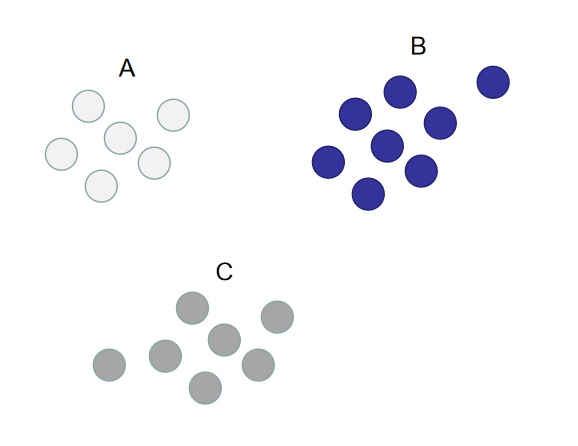

如果想要使用逻辑回归算法来解决这种3分类问题，可以使用OvR。OvR(One Vs Rest)是使用二分类算法来解决多分类问题的一种策略。从字面意思可以看出它的核心思想就是一对剩余。一对剩余的意思是当要对n种类别的样本进行分类时，分别取一种样本作为一类，将剩余的所有类型的样本看做另一类，这样就形成了n个二分类问题。所以和OvO一样，在训练阶段需要进行划分。

划分也很简单，如下图所示：

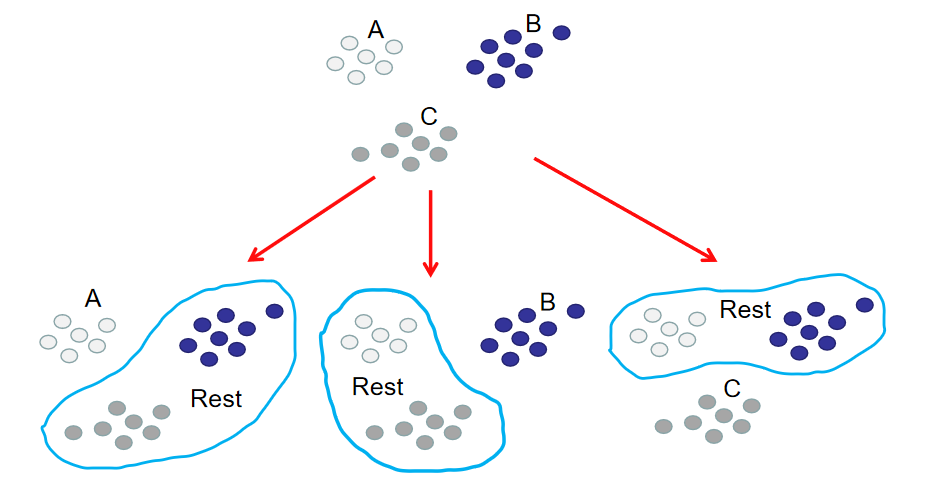

分别用这3种划分，划分出来的训练集训练二分类分类器，就能得到3个分类器。此时训练阶段已经完毕。如下图所示：

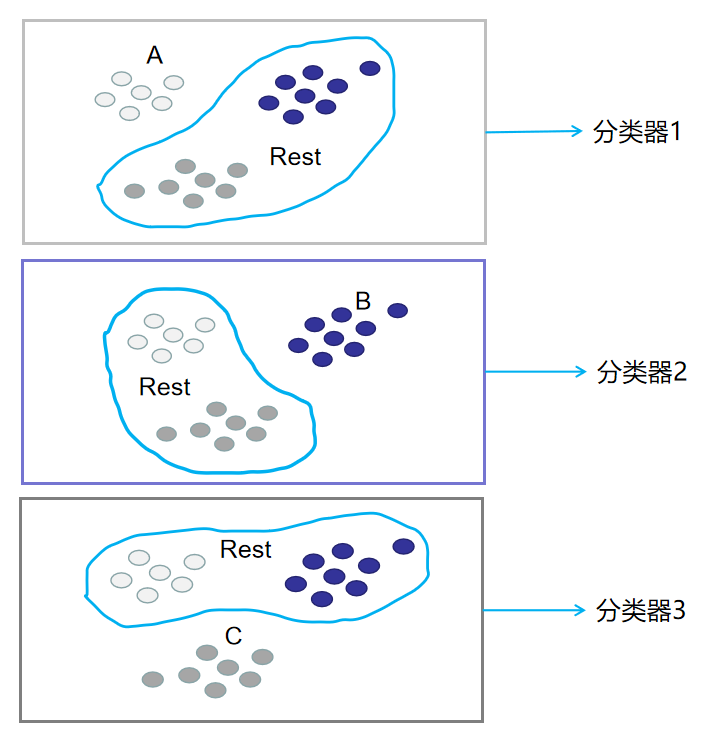

在预测阶段，只需要将测试样本分别扔给训练阶段训练好的3个分类器进行预测，最后选**概率最高**的类别作为最终结果。如下图所示：

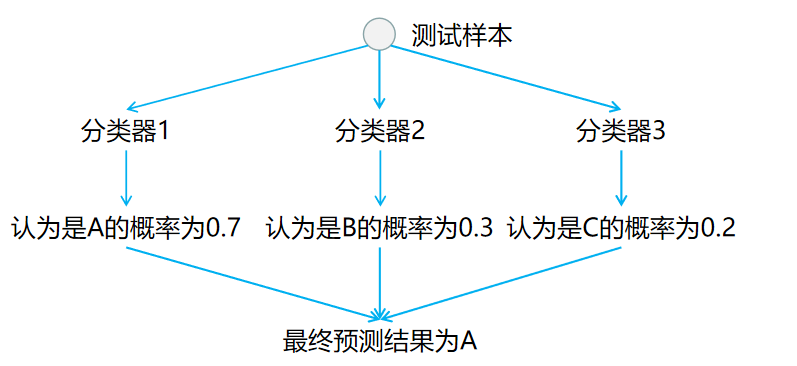

### 实操练习

#### 编程要求
根据提示，补充`Begin-End`之间的代码，完成`OvR`类中的`fit(self, train_datas, train_labels)`与`predict(self, test_datas)`函数。PS:请使用上述代码中所提供的`tiny_logistic_regression`作为二分类分类器。

#### 测试说明

输出预测准确率，应高于0.85

In [84]:
class OvR(object):
    def __init__(self):
        # 用于保存训练时各种模型的list
        self.models = []
        # 用于保存models中对应的正例的真实标签
        # 例如第1个模型的正例是2，则real_label[0]=2
        self.real_label = []
    def fit(self, train_datas, train_labels):
        '''
        OvO的训练阶段，将模型保存到self.models中
        :param train_datas: 训练集数据，类型为ndarray
        :param train_labels: 训练集标签，类型为ndarray，shape为(-1,)
        :return:None
        '''
        #********* Begin *********#
        unique_labels = list(set(train_labels))
        self.real_label = unique_labels
        # 划分并训练
        for i in range(len(unique_labels)):
            # label变为0，1
            label_1 = list(np.ones(len(train_labels[train_labels == unique_labels[i]])))
            label_0 = list(np.zeros(len(train_labels[train_labels != unique_labels[i]])))
            label_1.extend(label_0)
            labels = np.array(label_1)
            data_1 = list(train_datas[train_labels == unique_labels[i]])
            data_0 = list(train_datas[train_labels != unique_labels[i]])
            data_1.extend(data_0)
            datas = np.array(data_1)
            lr = tiny_logistic_regression()
            lr.fit(datas, labels)
            self.models.append(lr)
        #********* End *********#
    def predict(self, test_datas):
        '''
        OvO的预测阶段
        :param test_datas:测试集数据，类型为ndarray
        :return:预测结果，类型为ndarray
        '''
        #********* Begin *********#
        def _predict(models, real_labels, test_data):
            # 变形
            test_data = np.reshape(test_data, (1, -1))
            max_prob = 0
            max_prob_idx = 0
            for i, model in enumerate(models):
                pred_prob = model.predict_proba(test_data)[0]
                if pred_prob > max_prob:
                    max_prob = pred_prob
                    max_prob_idx = i
            return max_prob_idx
        predict = []
        for data in test_datas:
            predict.append(self.real_label[_predict(self.models, self.real_label, data)])
        return np.array(predict)
        #********* End *********#

In [85]:
# 创建模型
p = OvR()
# 训练模型
p.fit(X_train, y_train)
# 预测
y_pred = p.predict(X_test)
# 计算准确率
acc = accuracy_score(y_pred, y_test)
acc

0.8666666666666667